In [1]:
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm as log_progress

In [8]:
#load and clean data
#MODEL_NAME = "Test"
MODEL_NAME = 'shakespear2.0'
data_file_name = "aim-high.epub.txt"
SEQUENCE_LENGTH = 17 #how many items are fed into the ai per sequence

raw = open("data/" + data_file_name, "r", encoding='utf-8')

lines = []
print("Loading data...")
for line in log_progress(raw):
    if str(line) != '\n':
        lines.append(str(line))

print("Tokenizing...")
#putting the entirety of the input data into one string
text = ""
for line in log_progress(lines):
    text += line
#tokenizer = RegexpTokenizer(r'[a-zA-Z]')
tokenizer = RegexpTokenizer(r'\w+')
#tokenized = tokenizer.tokenize(text)
tokenized = [item for item in text]

#converting the text into numbers to be processed by the embedding layer of the model
words = [] #one of each word in tokenized will be in here
filtering = lambda x : not x in words #for finding if the word should be added to the words array
find = lambda x : float(words.index(x)) if x in words else float(len(words)) #convert each word into a number. -1 means that the item isn't in the vocabulary
normalize = lambda x: [find(i)/len(words) for i in x]

def convert_to_array(word_arr):
    out = []
    for i in range(len(word_arr)):
        arr = [0] * (len(words)+1)
        arr[i] = 1
        out.append(arr)
    return out
    
print("Finding every unique word...")
for word in log_progress(tokenized):
    if filtering(word):
        words.append(word)

#x data is every single word in the data set, in order
#y data is every single word that comes after the corresponding x value
x = []
y = []
print("Compiling dataset...")
for i in log_progress(range(int(len(tokenized) - SEQUENCE_LENGTH))):
    #x.append(convert_to_array(tokenized[i:i+SEQUENCE_LENGTH]))
    
    x.append(normalize(tokenized[i:i+SEQUENCE_LENGTH]))
    y.append(find(tokenized[i+SEQUENCE_LENGTH]))

x = np.asarray(x, np.float32)
y = np.asarray(y, np.float32)

x = np.reshape(x, (x.shape[0], SEQUENCE_LENGTH, 1))
y = to_categorical(y)

print(x.shape)
print(y.shape)

vocab_size = len(words)

Loading data...


0it [00:00, ?it/s]

Tokenizing...


  0%|          | 0/7247 [00:00<?, ?it/s]

Finding every unique word...


  0%|          | 0/1501786 [00:00<?, ?it/s]

Compiling dataset...


  0%|          | 0/1501769 [00:00<?, ?it/s]

(1501769, 17, 1)
(1501769, 83)


In [16]:
#create and compile model
model = Sequential()

model.add(LSTM(300, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(256))
model.add(Dropout(0.3))

model.add(Dense(y.shape[1], activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 17, 300)           362400    
                                                                 
 dropout_2 (Dropout)         (None, 17, 300)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               570368    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 83)                21331     
                                                                 
Total params: 954,099
Trainable params: 954,099
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/2
21119/21119 [==============================] - 192s 9ms/step - loss: 1.4114 - val_loss: 1.3984
Epoch 2/2
21119/21119 [==============================] - 188s 9ms/step - loss: 1.3840 - val_loss: 1.3712


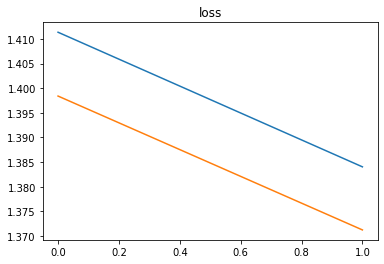

In [18]:
#train model
hist = model.fit(x, y, epochs=2, verbose=1, batch_size=64, validation_split=0.1)
model.save(MODEL_NAME + ".h5")

plt.title("loss")
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.show()

In [19]:
#test model
sample_length = 200
model = load_model("shakespear2.0.h5")

#get input sentence and process
sentence = input("Enter first " + str(SEQUENCE_LENGTH) + " letters... ").lower()

def process(data):
    output = normalize([data])
    output = np.asarray(output, np.float32)
    output = np.reshape(output, (output.shape[0], 1, SEQUENCE_LENGTH))
    return output

tokenized = [item for item in sentence]
root = []
if len(tokenized) <= SEQUENCE_LENGTH:
    print("Input text isn't long enough!")
    while True:
        pass
    
for i in range(int(len(tokenized) - SEQUENCE_LENGTH)):
    root.append(normalize(tokenized[i:i+SEQUENCE_LENGTH]))
root = np.asarray(root, np.float32)
root = np.reshape(root, (root.shape[0], SEQUENCE_LENGTH, 1))

last_input = root[root.shape[0]-1]

output = sentence
pred = model.predict(root, verbose=0)
sequence = sentence[len(output)-SEQUENCE_LENGTH-2:len(output)-1]

for i in log_progress(range(sample_length)):
    tokenized = [item for item in sequence]
    
    root = []
    for i in range(int(len(tokenized) - SEQUENCE_LENGTH)):
        root.append(normalize(tokenized[i:i+SEQUENCE_LENGTH]))
    root = np.asarray(root, np.float32)
    root = np.reshape(root, (root.shape[0], SEQUENCE_LENGTH, 1))
    
    tmp = root[root.shape[0]-1]
    tmp = np.reshape(tmp, (1, SEQUENCE_LENGTH, 1))
    
    
    pred = model.predict(tmp, verbose=0)
    #output += words[np.random.choice(len(pred[pred.shape[0]-1]), p=pred[pred.shape[0]-1])]
    sequence = sequence[1:]
    sequence += words[pred.argmax()]
    output += words[pred.argmax()]

print(output)

Enter first 17 letters... this is one big test


  0%|          | 0/200 [00:00<?, ?it/s]

this is one big testare dshnn inn overr etiemsot  on ote  on at  anroeert  an ote  on at  anroeert  an ote  on at  anroeert  an ote  on at  anroeert  an ote  on at  anroeert  an ote  on at  anroeert  an ote  on at  anroe


In [ ]:
output = sentence + " "
for i in log_progress(range(sample_length)):
    tmp = np.array(root)
    tmp = np.reshape(tmp, (1, 1, SEQUENCE_LENGTH))
    pred = model.predict(tmp, verbose=0)
    next_word = pred.argmax()
    #next_word = np.random.choice(len(pred[0]), p=pred[0])
    output += words[next_word]
    root.pop(0)
    root.append(next_word) #setting the next word
'np.argmax(model.predict(x), axis=-1)'